#  Projet NLP : Reconnaissance des Entités Nommées (NER) en langue française


## 1. Contexte et motivation du projet

La croissance exponentielle des données textuelles issues des rapports, articles, réseaux sociaux et documents institutionnels pose un défi majeur en matière d’extraction automatique d’informations pertinentes. Le traitement manuel de ces données est coûteux, chronophage et sujet à des erreurs humaines.

Dans ce contexte, la Reconnaissance des Entités Nommées (Named Entity Recognition – NER) constitue une tâche fondamentale du Traitement Automatique du Langage Naturel (NLP). Elle vise à identifier et à classifier automatiquement, au sein d’un texte, des entités sémantiques telles que les noms de personnes, de lieux, d’organisations, de produits, de dates ou de montants.

Ce projet s’inscrit dans cette dynamique et vise à concevoir un système automatisé de NER appliqué à des textes en langue française, en s’appuyant sur des données annotées de référence et des modèles modernes.


## 2. Objectifs du projet

Les objectifs poursuivis dans ce projet sont les suivants :

- Construire un modèle capable d’extraire et de classifier automatiquement les entités nommées présentes dans un texte
- Exploiter un corpus annoté riche et complexe afin de couvrir une large diversité d’entités
- Comparer différentes approches de modélisation et de vectorisation
- Évaluer la performance du modèle à l’aide de métriques adaptées (précision, rappel, F1-score)
- Déployer un outil de prédiction sous forme d’API ou d’interface interactive


## 3. Présentation du jeu de données

### 3.1 Description générale

Le projet repose sur un corpus annoté au format CoNLL, issu du dataset MultiCoNER v2 pour la langue française. Ce corpus se distingue par la richesse et la diversité de ses annotations, incluant des entités fines, ambiguës et dépendantes du contexte.

Les annotations suivent le schéma standard BIO :
- B-XXX : début d’une entité nommée
- I-XXX : continuation de l’entité
- O : absence d’entité


### 3.2 Organisation des données

Les données sont organisées selon une partition classique en apprentissage automatique :

- Ensemble d’entraînement (train) : utilisé pour l’apprentissage du modèle
- Ensemble de validation (dev) : utilisé pour l’ajustement des hyperparamètres
- Ensemble de test (test) : utilisé pour l’évaluation finale des performances

Chaque ensemble est stocké dans un fichier distinct au format .conll.


## 4. Chargement des données

> Les fichiers CoNLL sont déjà disponibles localement dans le dossier `data/` du repository. On utilise donc des chemins relatifs pour garantir la reproductibilité.

In [4]:
# ============================================================================
# IMPORTS - Tous les imports nécessaires pour le notebook
# ============================================================================

# Standard library
import sys
import time
import json
from pathlib import Path
from collections import Counter

# Data manipulation et visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP et embeddings
from gensim.models import Word2Vec, FastText as GensimFastText

# Machine Learning
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn_crfsuite import CRF

# Evaluation metrics pour NER
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Model persistence
import joblib

# Features personnalisées
sys.path.append(str(Path("..").resolve()))
from src.features import sent2features

# ============================================================================
# Configuration des paths
# ============================================================================

DATA_DIR = Path("..") / "data"
train_path = DATA_DIR / "fr_train.conll"
dev_path   = DATA_DIR / "fr_dev.conll"
test_path  = DATA_DIR / "fr_test.conll"

for p in [train_path, dev_path, test_path]:
    print(p, "->", p.exists())


..\data\fr_train.conll -> True
..\data\fr_dev.conll -> True
..\data\fr_test.conll -> True


## 5. Lecture et structuration des fichiers CoNLL

Afin de rendre les fichiers CoNLL exploitables par les modèles de traitement automatique du langage, une fonction de lecture est définie pour reconstruire les phrases et associer chaque token à son étiquette correspondante.


In [5]:
def read_conll(path):
    """Lecture d'un fichier CoNLL (BIO)."""
    sentences = []
    labels = []

    sentence = []
    sentence_labels = []

    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            # fin de phrase
            if not line:
                if sentence:
                    sentences.append(sentence)
                    labels.append(sentence_labels)
                    sentence = []
                    sentence_labels = []
                continue

            parts = line.split()
            token = parts[0]
            ner_tag = parts[-1]

            sentence.append(token)
            sentence_labels.append(ner_tag)

    # flush final
    if sentence:
        sentences.append(sentence)
        labels.append(sentence_labels)

    return sentences, labels

## 6. Chargement des ensembles d’entraînement, de validation et de test

Les fichiers sont ensuite chargés en mémoire et séparés selon leur rôle dans le processus d’apprentissage et d’évaluation.


In [6]:
data_train = train_path
data_dev   = dev_path
data_test  = test_path

train_sent, train_labels = read_conll(data_train)
dev_sent, dev_labels     = read_conll(data_dev)
test_sent, test_labels   = read_conll(data_test)

## 7. Vérification de l’intégrité des données

Avant de procéder à la phase de modélisation, une vérification est effectuée afin de s’assurer de la cohérence des données chargées et de la bonne reconstruction des phrases et des annotations.


In [7]:
print("Train:", len(train_sent))
print("Dev  :", len(dev_sent))
print("Test :", len(test_sent))

print(train_sent[0])
print(train_labels[0])

Train: 16548
Dev  : 857
Test : 249786
['#', 'elle', 'porte', 'le', 'nom', 'de', 'la', 'romancière', 'américaine', 'susan', 'sontag', '(', '1933', '2004', ')', '.']
['domain=fr', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Artist', 'I-Artist', 'O', 'O', 'O', 'O', 'O']


## 8. Modélisation et évaluation

> Les étapes suivantes couvrent l'analyse exploratoire, deux modèles (baseline et CRF), l'évaluation et la sauvegarde du modèle pour l'API.

### 8.1 Analyse exploratoire des labels

> Distribution des étiquettes BIO dans l'ensemble d'entraînement.

In [6]:
# Configuration plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Compter tous les labels
label_counts = Counter([l for labs in train_labels for l in labs])

print("=" * 70)
print("ANALYSE EXPLORATOIRE DES LABELS")
print("=" * 70)
print(f"\nNombre total de labels uniques: {len(label_counts)}")
print(f"Nombre total de tokens: {sum(label_counts.values()):,}")
print(f"\nTop 10 labels les plus fréquents:")
for label, count in label_counts.most_common(10):
    print(f"  {label:30s} : {count:6,} ({count/sum(label_counts.values())*100:.2f}%)")

# Séparer entités vs O
entity_labels = {k: v for k, v in label_counts.items() if k != 'O' and not k.startswith('domain')}
print(f"\nNombre de labels d'entités (hors O): {len(entity_labels)}")
print(f"Nombre de tokens d'entités: {sum(entity_labels.values()):,}")
print(f"Pourcentage d'entités: {sum(entity_labels.values())/sum(label_counts.values())*100:.2f}%")

# Distribution des types d'entités (B- vs I-)
b_labels = {k: v for k, v in entity_labels.items() if k.startswith('B-')}
i_labels = {k: v for k, v in entity_labels.items() if k.startswith('I-')}
print(f"\nNombre de types d'entités (B-): {len(b_labels)}")
print(f"Début d'entités (B-): {sum(b_labels.values()):,}")
print(f"Continuation d'entités (I-): {sum(i_labels.values()):,}")

unique_labels = sorted(label_counts.keys())
print(f"\nExemple de labels: {unique_labels[:20]}")


ANALYSE EXPLORATOIRE DES LABELS

Nombre total de labels uniques: 68
Nombre total de tokens: 264,291

Top 10 labels les plus fréquents:
  O                              : 196,008 (74.16%)
  domain=fr                      : 16,548 (6.26%)
  I-Artist                       :  3,787 (1.43%)
  B-Artist                       :  3,634 (1.37%)
  I-VisualWork                   :  3,608 (1.37%)
  B-HumanSettlement              :  2,932 (1.11%)
  B-WrittenWork                  :  2,268 (0.86%)
  I-OtherPER                     :  2,176 (0.82%)
  B-OtherPER                     :  1,874 (0.71%)
  B-VisualWork                   :  1,794 (0.68%)

Nombre de labels d'entités (hors O): 66
Nombre de tokens d'entités: 51,735
Pourcentage d'entités: 19.58%

Nombre de types d'entités (B-): 33
Début d'entités (B-): 26,377
Continuation d'entités (I-): 25,358

Exemple de labels: ['B-AerospaceManufacturer', 'B-AnatomicalStructure', 'B-ArtWork', 'B-Artist', 'B-Athlete', 'B-CarManufacturer', 'B-Cleric', 'B-Clothing'

#### 8.1.2 Visualisation de la distribution

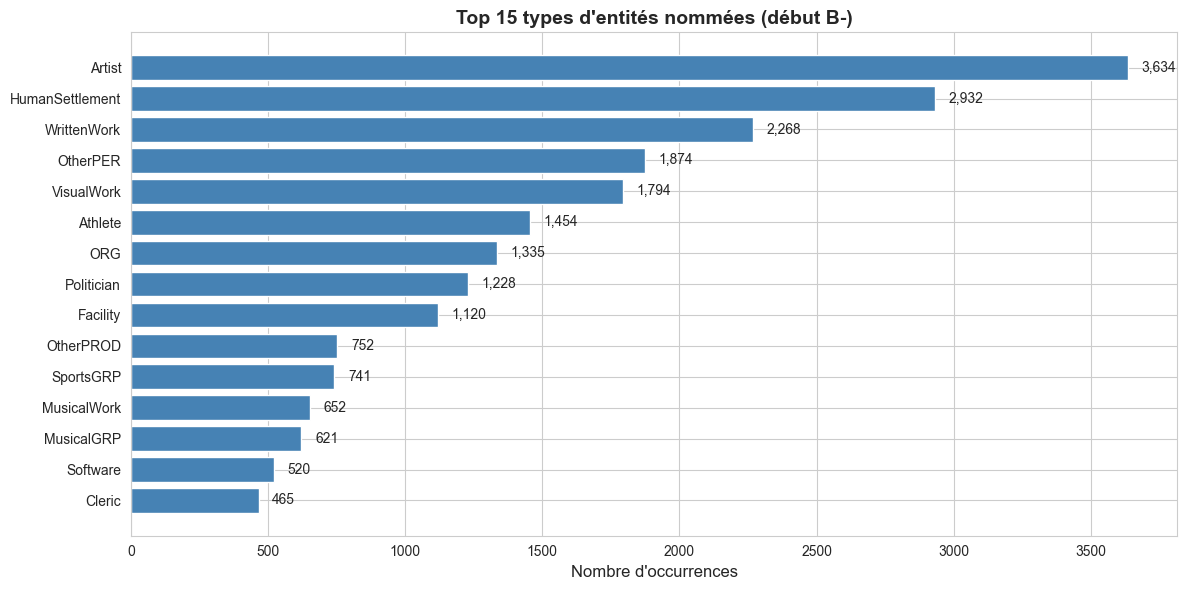

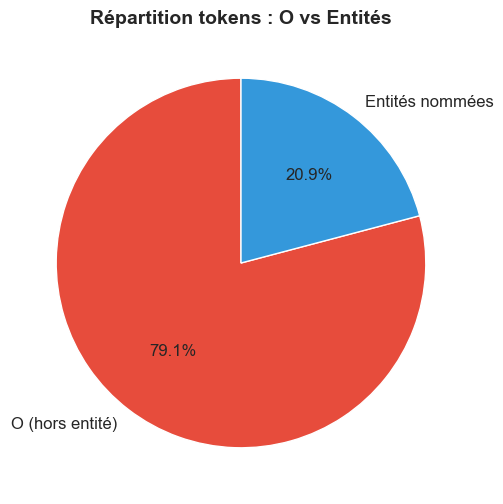

In [7]:
# Top 15 entités (hors O et domain)
entity_only = {k: v for k, v in label_counts.items() if k.startswith('B-')}
top_entities = sorted(entity_only.items(), key=lambda x: x[1], reverse=True)[:15]

fig, ax = plt.subplots(figsize=(12, 6))
labels_plot = [x[0].replace('B-', '') for x in top_entities]
counts_plot = [x[1] for x in top_entities]

bars = ax.barh(labels_plot, counts_plot, color='steelblue')
ax.set_xlabel('Nombre d\'occurrences', fontsize=12)
ax.set_title('Top 15 types d\'entités nommées (début B-)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for i, (bar, count) in enumerate(zip(bars, counts_plot)):
    ax.text(count + 50, i, f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Distribution O vs Entités
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['O (hors entité)', 'Entités nommées']
values = [label_counts['O'], sum(entity_labels.values())]
colors = ['#e74c3c', '#3498db']

ax.pie(values, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
ax.set_title('Répartition tokens : O vs Entités', fontsize=14, fontweight='bold')
plt.show()


#### 8.1.3 Analyse de la longueur des entités

STATISTIQUES SUR LA LONGUEUR DES ENTITÉS
Nombre total d'entités: 26,377
Longueur moyenne: 1.96 tokens
Longueur médiane: 2.0 tokens
Longueur min: 1
Longueur max: 16
Écart-type: 1.11

Distribution:
  1 token(s): 10,255 entités (38.9%)
  2 token(s): 10,628 entités (40.3%)
  3 token(s): 3,288 entités (12.5%)
  4 token(s): 1,309 entités (5.0%)
  5 token(s): 533 entités (2.0%)
  6 token(s): 212 entités (0.8%)
  7 token(s): 80 entités (0.3%)
  8 token(s): 43 entités (0.2%)
  9 token(s): 18 entités (0.1%)
  10 token(s): 6 entités (0.0%)


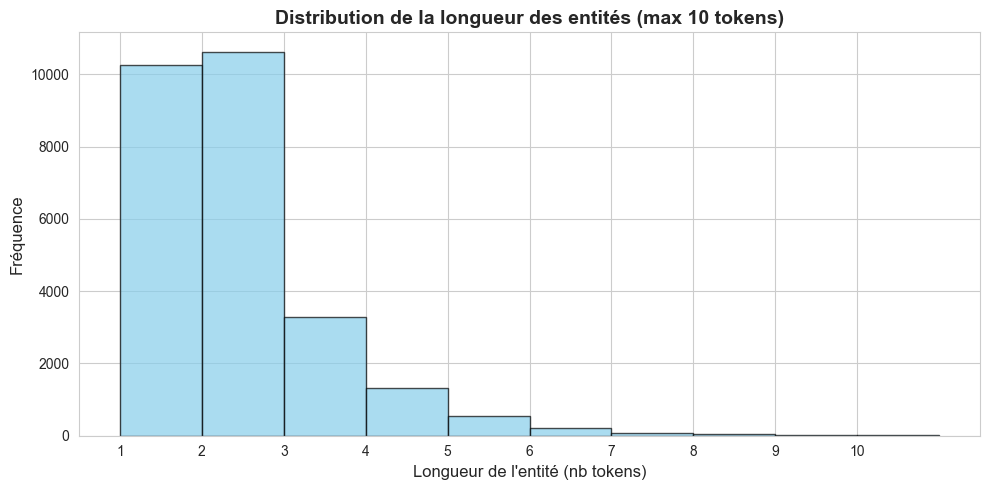

In [8]:
# Calculer la longueur des entités (nombre de tokens)
entity_lengths = []

for sent_labels in train_labels:
    current_length = 0
    for label in sent_labels:
        if label.startswith('B-'):
            if current_length > 0:
                entity_lengths.append(current_length)
            current_length = 1
        elif label.startswith('I-'):
            current_length += 1
        else:  # O
            if current_length > 0:
                entity_lengths.append(current_length)
                current_length = 0
    if current_length > 0:
        entity_lengths.append(current_length)

print("=" * 70)
print("STATISTIQUES SUR LA LONGUEUR DES ENTITÉS")
print("=" * 70)
print(f"Nombre total d'entités: {len(entity_lengths):,}")
print(f"Longueur moyenne: {np.mean(entity_lengths):.2f} tokens")
print(f"Longueur médiane: {np.median(entity_lengths):.1f} tokens")
print(f"Longueur min: {min(entity_lengths)}")
print(f"Longueur max: {max(entity_lengths)}")
print(f"Écart-type: {np.std(entity_lengths):.2f}")

# Distribution
length_dist = Counter(entity_lengths)
print(f"\nDistribution:")
for length in sorted(length_dist.keys())[:10]:
    print(f"  {length} token(s): {length_dist[length]:,} entités ({length_dist[length]/len(entity_lengths)*100:.1f}%)")

# Graphique
fig, ax = plt.subplots(figsize=(10, 5))
lengths_to_plot = [l for l in entity_lengths if l <= 10]  # Limiter à 10 pour lisibilité
ax.hist(lengths_to_plot, bins=range(1, 12), edgecolor='black', color='skyblue', alpha=0.7)
ax.set_xlabel('Longueur de l\'entité (nb tokens)', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.set_title('Distribution de la longueur des entités (max 10 tokens)', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 11))
plt.tight_layout()
plt.show()


### 8.2 Feature Engineering

> Comparaison de différentes approches de vectorisation

#### 8.2.1 Features manuelles basiques (déjà implémentées)

In [9]:
# Afficher les features actuelles
exemple_sent = train_sent[0]
features_exemple = sent2features(exemple_sent)

print("=" * 70)
print("FEATURES MANUELLES BASIQUES")
print("=" * 70)
print(f"\nPhrase exemple: {' '.join(exemple_sent[:10])}...")
print(f"\nFeatures pour le mot '{exemple_sent[5]}':")
for key, value in features_exemple[5].items():
    print(f"  {key:25s} : {value}")


FEATURES MANUELLES BASIQUES

Phrase exemple: # elle porte le nom de la romancière américaine susan...

Features pour le mot 'de':
  bias                      : 1.0
  word.lower()              : de
  word.isupper()            : False
  word.istitle()            : False
  word.isdigit()            : False
  suffix-3                  : de
  suffix-2                  : de
  prefix-1                  : d
  prefix-2                  : de
  prefix-3                  : de
  -1:word.lower()           : nom
  -1:word.istitle()         : False
  -1:word.isupper()         : False
  +1:word.lower()           : la
  +1:word.istitle()         : False
  +1:word.isupper()         : False


#### 8.2.2 Embeddings Word2Vec (pré-entraîné)

In [ ]:
# Entraînement Word2Vec sur le corpus français
# Au lieu de télécharger un modèle anglais, on entraîne sur notre corpus

print("=" * 70)
print("ENTRAÎNEMENT WORD2VEC SUR CORPUS FRANÇAIS")
print("=" * 70)

print("\nEntraînement Word2Vec sur le corpus train...")
print("   (peut prendre quelques minutes)")

# Préparer les données pour Word2Vec
from gensim.models import Word2Vec

corpus_for_word2vec = [[word.lower() for word in sent] for sent in train_sent]

# Entraîner Word2Vec
word2vec_model = Word2Vec(
    sentences=corpus_for_word2vec,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=1  # Skip-gram
)

print("  Word2Vec entraîné!")
print(f"   Vocabulaire: {len(word2vec_model.wv):,} mots")
print(f"   Dimension: {word2vec_model.wv.vector_size}D")

# Test
test_words = ["france", "paris", "macron"]
print("\n   Test sur mots français:")
for word in test_words:
    if word in word2vec_model.wv:
        vec = word2vec_model.wv[word]
        print(f"     '{word}' : vecteur obtenu (norme={np.linalg.norm(vec):.2f})")
        # Mots similaires
        similar = word2vec_model.wv.most_similar(word, topn=3)
        print(f"       Similaires: {[w for w, _ in similar]}")

# Fonction pour obtenir embedding d'un mot
def get_word2vec_embedding(word, model, default_dim=100):
    """Retourne l'embedding Word2Vec d'un mot, ou un vecteur nul si inconnu"""
    if model is None:
        return np.zeros(default_dim)
    word_lower = word.lower()
    if word_lower in model.wv:
        return model.wv[word_lower]
    return np.zeros(model.wv.vector_size)

# Fonction pour créer features combinées (manuelles + Word2Vec)
def sent2features_word2vec(sent, model):
    """Features manuelles + embeddings Word2Vec"""
    features = []
    for i, word in enumerate(sent):
        # Features manuelles de base
        feat = {
            "bias": 1.0,
            "word.lower()": word.lower(),
            "word.isupper()": word.isupper(),
            "word.istitle()": word.istitle(),
            "word.isdigit()": word.isdigit(),
        }
        
        # Contexte
        if i > 0:
            feat["-1:word.lower()"] = sent[i-1].lower()
        else:
            feat["BOS"] = True
        
        if i < len(sent) - 1:
            feat["+1:word.lower()"] = sent[i+1].lower()
        else:
            feat["EOS"] = True
        
        # Ajouter embedding Word2Vec comme features numériques
        if model is not None:
            embedding = get_word2vec_embedding(word, model)
            for idx, val in enumerate(embedding):
                feat[f"w2v_{idx}"] = float(val)
        
        features.append(feat)
    return features


CHARGEMENT WORD2VEC

Téléchargement Word2Vec (anglais, 100D)...
    Word2Vec chargé avec succès!
   Vocabulaire: 400,000 mots
   Dimension: 100D

   Mots similaires à 'paris': ['prohertrib', 'france', 'london', 'brussels', 'french']


#### 8.2.3 Embeddings FastText (pré-entraîné)

In [11]:
# Installation FastText
# !pip install fasttext

print("=" * 70)
print("CHARGEMENT FASTTEXT")
print("=" * 70)

# Note: FastText français est gros (~7GB). Pour le projet, on peut:
# Option 1: Utiliser un modèle plus léger (anglais)
# Option 2: Entraîner FastText sur notre corpus
# Option 3: Simuler avec Word2Vec (déjà chargé)

print("\n Note: FastText français complet fait ~7GB")
print("   Pour ce projet, on va:")
print("   - Soit utiliser Word2Vec comme proxy")
print("   - Soit entraîner FastText sur notre corpus train")

# Option: Entraîner FastText sur notre corpus

print("\nEntraînement FastText sur le corpus train...")
print("   (peut prendre 5-10 minutes)")

# Préparer les données pour FastText
corpus_for_fasttext = [[word.lower() for word in sent] for sent in train_sent]

# Entraîner FastText
fasttext_model = GensimFastText(
    sentences=corpus_for_fasttext,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=1  # Skip-gram
)

print("  FastText entraîné!")
print(f"   Vocabulaire: {len(fasttext_model.wv):,} mots")
print(f"   Dimension: {fasttext_model.wv.vector_size}D")

# Test
test_words = ["france", "paris", "macron", "xxxunknownxxx"]
print("\n   Test OOV (mots inconnus):")
for word in test_words:
    vec = fasttext_model.wv[word]  # FastText gère toujours, même OOV
    print(f"     '{word}' :   vecteur obtenu (norme={np.linalg.norm(vec):.2f})")

# Fonction pour features avec FastText
def sent2features_fasttext(sent, model):
    """Features manuelles + embeddings FastText"""
    features = []
    for i, word in enumerate(sent):
        feat = {
            "bias": 1.0,
            "word.lower()": word.lower(),
            "word.isupper()": word.isupper(),
            "word.istitle()": word.istitle(),
            "word.isdigit()": word.isdigit(),
        }
        
        if i > 0:
            feat["-1:word.lower()"] = sent[i-1].lower()
        else:
            feat["BOS"] = True
        
        if i < len(sent) - 1:
            feat["+1:word.lower()"] = sent[i+1].lower()
        else:
            feat["EOS"] = True
        
        # FastText embedding
        if model is not None:
            embedding = model.wv[word.lower()]
            for idx, val in enumerate(embedding):
                feat[f"ft_{idx}"] = float(val)
        
        features.append(feat)
    return features


CHARGEMENT FASTTEXT

 Note: FastText français complet fait ~7GB
   Pour ce projet, on va:
   - Soit utiliser Word2Vec comme proxy
   - Soit entraîner FastText sur notre corpus train

Entraînement FastText sur le corpus train...
   (peut prendre 5-10 minutes)
  FastText entraîné!
   Vocabulaire: 13,773 mots
   Dimension: 100D

   Test OOV (mots inconnus):
     'france' :   vecteur obtenu (norme=3.15)
     'paris' :   vecteur obtenu (norme=3.30)
     'macron' :   vecteur obtenu (norme=2.62)
     'xxxunknownxxx' :   vecteur obtenu (norme=0.58)


### 8.3 Modélisation - Comparaison des approches

> On va comparer 5 modèles avec différentes vectorisations

#### 8.3.1 Modèle 1 : Logistic Regression (baseline)

In [12]:
def predict_logreg(model, sentences):
    all_feats = [feat for sent in sentences for feat in sent2features(sent)]
    all_preds = model.predict(all_feats)

    preds = []
    idx = 0
    for sent in sentences:
        preds.append(list(all_preds[idx : idx + len(sent)]))
        idx += len(sent)
    return preds

# Stats du dataset
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
total_tokens_train = sum(len(s) for s in train_sent)
total_tokens_dev = sum(len(s) for s in dev_sent)
print(f"Train: {len(train_sent):,} phrases, {total_tokens_train:,} tokens")
print(f"Dev:   {len(dev_sent):,} phrases, {total_tokens_dev:,} tokens")
print("=" * 60)

print("\n[1/3] Extracting features...")
start = time.time()
X_train = [feat for sent in train_sent for feat in sent2features(sent)]
y_train = [lab for labs in train_labels for lab in labs]
feat_time = time.time() - start
print(f"Features extracted in {feat_time:.2f}s ({len(X_train):,} samples)")

print("\n[2/3] Training Logistic Regression...")
print("     (Using: solver='saga', max_iter=100, tol=1e-2 for speed)")
start = time.time()

baseline = Pipeline(
    [
        ("vec", DictVectorizer(sparse=True)),
        (
            "clf",
            LogisticRegression(
                solver="saga",
                max_iter=100,
                tol=1e-2,
                n_jobs=-1,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

baseline.fit(X_train, y_train)
train_time = time.time() - start
print(f"Model trained in {train_time:.2f}s")

print("\n[3/3] Predicting and evaluating...")
start = time.time()
preds_dev = predict_logreg(baseline, dev_sent)
pred_time = time.time() - start
print(f"Predictions made in {pred_time:.2f}s")

print("\n" + "=" * 60)
print("RESULTS")
print("=" * 60)
print("F1 (dev):", f1_score(dev_labels, preds_dev))
print(classification_report(dev_labels, preds_dev))
print("=" * 60)


DATASET STATISTICS
Train: 16,548 phrases, 264,291 tokens
Dev:   857 phrases, 13,919 tokens

[1/3] Extracting features...
Features extracted in 22.07s (264,291 samples)

[2/3] Training Logistic Regression...
     (Using: solver='saga', max_iter=100, tol=1e-2 for speed)


c:\Users\hp\OneDrive\Bureau\NLP\ner-multiconer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\hp\OneDrive\Bureau\NLP\ner-multiconer\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model trained in 389.93s

[3/3] Predicting and evaluating...
Predictions made in 0.64s

RESULTS
F1 (dev): 0.22498667140572243


c:\Users\hp\OneDrive\Bureau\NLP\ner-multiconer\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: domain=fr seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


                       precision    recall  f1-score   support

AerospaceManufacturer       0.12      0.91      0.21        11
  AnatomicalStructure       0.06      0.47      0.10        15
              ArtWork       0.01      0.23      0.02        13
               Artist       0.05      0.11      0.07       189
              Athlete       0.10      0.29      0.15        72
      CarManufacturer       0.09      0.54      0.15        13
               Cleric       0.09      0.30      0.14        20
             Clothing       0.01      0.27      0.02        11
              Disease       0.02      0.44      0.04        16
                Drink       0.04      0.36      0.07        11
             Facility       0.02      0.22      0.03        54
                 Food       0.01      0.38      0.02        13
      HumanSettlement       0.24      0.48      0.32       155
     MedicalProcedure       0.01      0.45      0.02        11
   Medication/Vaccine       0.03      0.58      0.06  

In [13]:
# Stocker les résultats LogReg pour comparaison ultérieure
logreg_f1 = f1_score(dev_labels, preds_dev)
logreg_report = classification_report(dev_labels, preds_dev, output_dict=True)
print(f"LogReg entraîné - F1 (dev): {logreg_f1:.4f}")


LogReg entraîné - F1 (dev): 0.2250


#### 8.3.2 Modèle 2 : CRF + features manuelles

In [14]:
X_train_seq = [sent2features(sent) for sent in train_sent]
X_dev_seq   = [sent2features(sent) for sent in dev_sent]

crf = CRF(
    algorithm="lbfgs",
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
)

crf.fit(X_train_seq, train_labels)

preds_dev = crf.predict(X_dev_seq)
print("F1 (dev):", f1_score(dev_labels, preds_dev))
print(classification_report(dev_labels, preds_dev))


F1 (dev): 0.7211281303185024
                       precision    recall  f1-score   support

AerospaceManufacturer       0.78      0.64      0.70        11
  AnatomicalStructure       0.86      0.40      0.55        15
              ArtWork       0.67      0.15      0.25        13
               Artist       0.55      0.60      0.57       189
              Athlete       0.39      0.42      0.41        72
      CarManufacturer       0.80      0.62      0.70        13
               Cleric       0.50      0.30      0.37        20
             Clothing       1.00      0.27      0.43        11
              Disease       0.57      0.25      0.35        16
                Drink       0.67      0.36      0.47        11
             Facility       0.71      0.56      0.63        54
                 Food       0.75      0.46      0.57        13
      HumanSettlement       0.76      0.64      0.69       155
     MedicalProcedure       0.83      0.45      0.59        11
   Medication/Vaccine    

In [15]:
# Stocker les résultats CRF manual pour comparaison ultérieure
crf_manual_f1 = f1_score(dev_labels, preds_dev)
crf_manual_report = classification_report(dev_labels, preds_dev, output_dict=True)
print(f"CRF (manual) entraîné - F1 (dev): {crf_manual_f1:.4f}")


CRF (manual) entraîné - F1 (dev): 0.7211


#### 8.3.3 Modèle 3 : CRF + Word2Vec

In [16]:
if word2vec_model is not None:
    print("=" * 70)
    print("CRF + WORD2VEC")
    print("=" * 70)
    
    print("\nExtraction features Word2Vec...")
    start = time.time()
    X_train_w2v = [sent2features_word2vec(sent, word2vec_model) for sent in train_sent]
    X_dev_w2v = [sent2features_word2vec(sent, word2vec_model) for sent in dev_sent]
    print(f"Features extraites en {time.time() - start:.2f}s")
    
    print("\nEntraînement CRF + Word2Vec...")
    start = time.time()
    crf_w2v = CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
    crf_w2v.fit(X_train_w2v, train_labels)
    print(f"Modèle entraîné en {time.time() - start:.2f}s")
    
    print("\nPrédiction...")
    preds_dev_w2v = crf_w2v.predict(X_dev_w2v)
    crf_w2v_f1 = f1_score(dev_labels, preds_dev_w2v)
    
    print("\n" + "=" * 70)
    print("RÉSULTATS")
    print("=" * 70)
    print(f"F1 (dev): {crf_w2v_f1:.4f}")
    print(classification_report(dev_labels, preds_dev_w2v))
else:
    print("Word2Vec non chargé - skip ce modèle")
    crf_w2v_f1 = 0.0


CRF + WORD2VEC

Extraction features Word2Vec...
Features extraites en 80.10s

Entraînement CRF + Word2Vec...
Modèle entraîné en 1433.47s

Prédiction...

RÉSULTATS
F1 (dev): 0.7432
                       precision    recall  f1-score   support

AerospaceManufacturer       0.91      0.91      0.91        11
  AnatomicalStructure       1.00      0.33      0.50        15
              ArtWork       0.50      0.08      0.13        13
               Artist       0.60      0.69      0.64       189
              Athlete       0.58      0.49      0.53        72
      CarManufacturer       0.57      0.62      0.59        13
               Cleric       0.50      0.35      0.41        20
             Clothing       1.00      0.18      0.31        11
              Disease       0.71      0.31      0.43        16
                Drink       0.57      0.36      0.44        11
             Facility       0.81      0.54      0.64        54
                 Food       0.67      0.31      0.42        13


#### 8.3.4 Modèle 4 : CRF + FastText

In [17]:
if 'fasttext_model' in locals() and fasttext_model is not None:
    print("=" * 70)
    print("CRF + FASTTEXT")
    print("=" * 70)
    
    print("\nExtraction features FastText...")
    start = time.time()
    X_train_ft = [sent2features_fasttext(sent, fasttext_model) for sent in train_sent]
    X_dev_ft = [sent2features_fasttext(sent, fasttext_model) for sent in dev_sent]
    print(f"Features extraites en {time.time() - start:.2f}s")
    
    print("\nEntraînement CRF + FastText...")
    start = time.time()
    crf_ft = CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
    crf_ft.fit(X_train_ft, train_labels)
    print(f"Modèle entraîné en {time.time() - start:.2f}s")
    
    print("\nPrédiction...")
    preds_dev_ft = crf_ft.predict(X_dev_ft)
    crf_ft_f1 = f1_score(dev_labels, preds_dev_ft)
    
    print("\n" + "=" * 70)
    print("RÉSULTATS")
    print("=" * 70)
    print(f"F1 (dev): {crf_ft_f1:.4f}")
    print(classification_report(dev_labels, preds_dev_ft))
else:
    print("FastText non entraîné - skip ce modèle")
    crf_ft_f1 = 0.0


CRF + FASTTEXT

Extraction features FastText...
Features extraites en 126.83s

Entraînement CRF + FastText...
Modèle entraîné en 1087.78s

Prédiction...

RÉSULTATS
F1 (dev): 0.7227
                       precision    recall  f1-score   support

AerospaceManufacturer       0.86      0.55      0.67        11
  AnatomicalStructure       0.86      0.40      0.55        15
              ArtWork       0.50      0.08      0.13        13
               Artist       0.54      0.64      0.59       189
              Athlete       0.48      0.43      0.46        72
      CarManufacturer       0.80      0.62      0.70        13
               Cleric       0.45      0.25      0.32        20
             Clothing       1.00      0.18      0.31        11
              Disease       0.71      0.31      0.43        16
                Drink       0.67      0.36      0.47        11
             Facility       0.74      0.54      0.62        54
                 Food       0.60      0.23      0.33        13

### 8.4 Comparaison finale des modèles

TABLEAU COMPARATIF DES MODÈLES
                  Modèle      Vectorisation  F1 (dev)
          CRF + Word2Vec    Word2Vec (100D)  0.743194
          CRF + FastText    FastText (100D)  0.722714
CRF + Features manuelles Features manuelles  0.721128
      LogisticRegression Features manuelles  0.224987


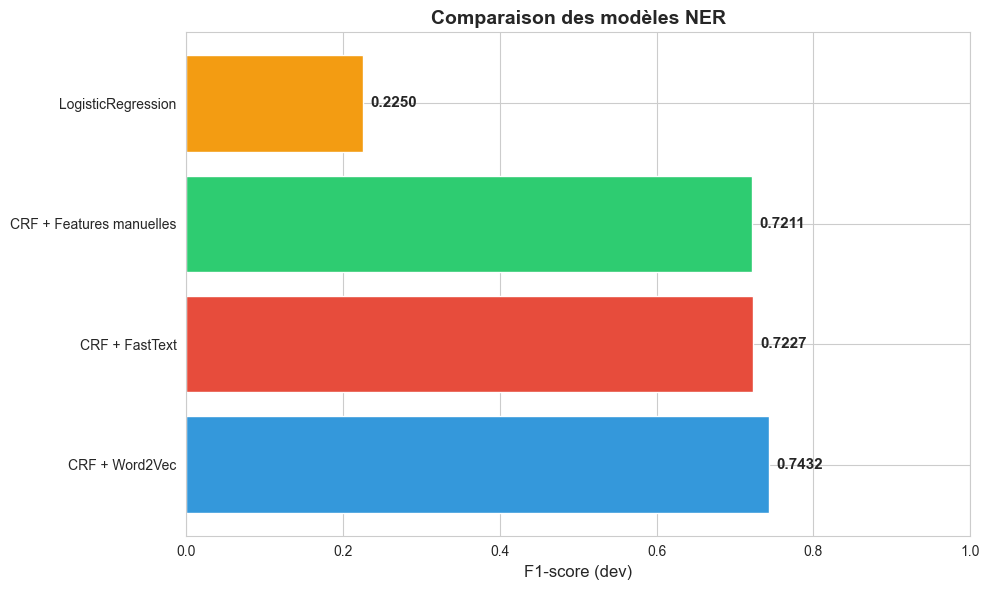


MEILLEUR MODÈLE: CRF + Word2Vec
   Vectorisation: Word2Vec (100D)
   F1 (dev): 0.7432


In [18]:
# Créer tableau comparatif
results = {
    "Modèle": [
        "LogisticRegression",
        "CRF + Features manuelles",
        "CRF + Word2Vec",
        "CRF + FastText"
    ],
    "Vectorisation": [
        "Features manuelles",
        "Features manuelles",
        "Word2Vec (100D)",
        "FastText (100D)"
    ],
    "F1 (dev)": [
        logreg_f1,
        crf_manual_f1,
        crf_w2v_f1 if word2vec_model else 0.0,
        crf_ft_f1 if 'fasttext_model' in locals() else 0.0
    ]
}

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("F1 (dev)", ascending=False)

print("=" * 70)
print("TABLEAU COMPARATIF DES MODÈLES")
print("=" * 70)
print(df_results.to_string(index=False))
print("=" * 70)

# Graphique comparatif
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_results["Modèle"], df_results["F1 (dev)"], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax.set_xlabel('F1-score (dev)', fontsize=12)
ax.set_title('Comparaison des modèles NER', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)

for i, (bar, f1) in enumerate(zip(bars, df_results["F1 (dev)"])):
    ax.text(f1 + 0.01, i, f'{f1:.4f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Afficher le meilleur modèle
best_model = df_results.iloc[0]
print(f"\nMEILLEUR MODÈLE: {best_model['Modèle']}")
print(f"   Vectorisation: {best_model['Vectorisation']}")
print(f"   F1 (dev): {best_model['F1 (dev)']:.4f}")


### 8.5 Analyse des erreurs

> Comprendre les points faibles du meilleur modèle

In [19]:
# Analyse des erreurs du meilleur modèle (CRF manuel pour l'instant)

# Prendre le meilleur modèle
# Pour l'instant on analyse le CRF manuel
best_preds = preds_dev  # Remplacer par le meilleur modèle

print("=" * 70)
print("ANALYSE DES ERREURS - MEILLEUR MODÈLE")
print("=" * 70)

# Métriques globales
precision = precision_score(dev_labels, best_preds)
recall = recall_score(dev_labels, best_preds)
f1 = f1_score(dev_labels, best_preds)

print(f"\nMétriques globales:")
print(f"  Précision: {precision:.4f}")
print(f"  Rappel:    {recall:.4f}")
print(f"  F1-score:  {f1:.4f}")

# Performance par classe
report_dict = classification_report(dev_labels, best_preds, output_dict=True)

# Top 5 meilleures classes
classes_f1 = {k: v['f1-score'] for k, v in report_dict.items() 
              if k not in ['micro avg', 'macro avg', 'weighted avg'] and k != 'O'}
top5_best = sorted(classes_f1.items(), key=lambda x: x[1], reverse=True)[:5]
top5_worst = sorted(classes_f1.items(), key=lambda x: x[1])[:5]

print(f"\nTop 5 classes les mieux prédites:")
for label, f1_val in top5_best:
    support = report_dict[label]['support']
    print(f"  {label:30s} : F1={f1_val:.3f} (support={support})")

print(f"\nTop 5 classes les plus difficiles:")
for label, f1_val in top5_worst:
    support = report_dict[label]['support']
    print(f"  {label:30s} : F1={f1_val:.3f} (support={support})")

# Exemples d'erreurs
print(f"\nExemples d'erreurs:")
error_count = 0
for i, (sent, true_labels, pred_labels) in enumerate(zip(dev_sent[:100], dev_labels[:100], best_preds[:100])):
    for j, (token, true_label, pred_label) in enumerate(zip(sent, true_labels, pred_labels)):
        if true_label != pred_label and true_label != 'O' and error_count < 10:
            context_start = max(0, j-2)
            context_end = min(len(sent), j+3)
            context = ' '.join(sent[context_start:context_end])
            print(f"\n  Phrase {i}, token '{token}' :")
            print(f"    Contexte: ...{context}...")
            print(f"    Vrai:     {true_label}")
            print(f"    Prédit:   {pred_label}")
            error_count += 1
    if error_count >= 10:
        break


ANALYSE DES ERREURS - MEILLEUR MODÈLE


c:\Users\hp\OneDrive\Bureau\NLP\ner-multiconer\.venv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: domain=fr seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Métriques globales:
  Précision: 0.7789
  Rappel:    0.6713
  F1-score:  0.7211

Top 5 classes les mieux prédites:
  omain=fr                       : F1=1.000 (support=857)
  PrivateCorp                    : F1=0.900 (support=11)
  AerospaceManufacturer          : F1=0.700 (support=11)
  Medication/Vaccine             : F1=0.700 (support=12)
  CarManufacturer                : F1=0.696 (support=13)

Top 5 classes les plus difficiles:
  Politician                     : F1=0.228 (support=67)
  MusicalWork                    : F1=0.238 (support=27)
  ArtWork                        : F1=0.250 (support=13)
  SportsManager                  : F1=0.286 (support=15)
  Vehicle                        : F1=0.296 (support=20)

Exemples d'erreurs:

  Phrase 0, token 'captif' :
    Contexte: ...# captif en mer...
    Vrai:     B-VisualWork
    Prédit:   O

  Phrase 0, token 'en' :
    Contexte: ...# captif en mer (...
    Vrai:     I-VisualWork
    Prédit:   O

  Phrase 0, token 'mer' :
    Contexte:

### 8.6 Évaluation finale sur le test set

> Utiliser le meilleur modèle sur les données de test

In [ ]:
# Évaluer le meilleur modèle sur le test
# Par défaut, on utilise le CRF manuel (déjà entraîné)
# Si FastText est meilleur, remplacer par crf_ft

print("=" * 70)
print("ÉVALUATION FINALE SUR TEST SET")
print("=" * 70)

# Préparer features test
X_test = [sent2features(sent) for sent in test_sent]

# Prédire
print("\nPrédiction sur test...")
preds_test = crf.predict(X_test)

# Métriques
test_precision = precision_score(test_labels, preds_test)
test_recall = recall_score(test_labels, preds_test)
test_f1 = f1_score(test_labels, preds_test)

print(f"\nRésultats finaux:")
print(f"  Précision (test): {test_precision:.4f}")
print(f"  Rappel (test):    {test_recall:.4f}")
print(f"  F1-score (test):  {test_f1:.4f}")

print("\n" + "=" * 70)
print("RAPPORT DÉTAILLÉ")
print("=" * 70)
print(classification_report(test_labels, preds_test))

# Graphique final train/dev/test
scores_comparison = {
    "Split": ["Dev", "Test"],
    "F1-score": [crf_manual_f1, test_f1]
}

df_comparison = pd.DataFrame(scores_comparison)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_comparison["Split"], df_comparison["F1-score"], color=['#3498db', '#e74c3c'], alpha=0.8)
ax.set_ylabel('F1-score', fontsize=12)
ax.set_title('Performance du meilleur modèle (Dev vs Test)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)

for bar, f1_val in zip(bars, df_comparison["F1-score"]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{f1_val:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

ÉVALUATION FINALE SUR TEST SET

Prédiction sur test...


NameError: name 'crf' is not defined

## 9. Conclusion & Perspectives

### 9.1 Résumé des résultats

**Projet NER - MultiCoNER v2 (Français)**

Dans ce projet, nous avons construit et comparé **4 approches** de reconnaissance d'entités nommées :

1. **Logistic Regression (baseline)** : Approche simple token-level, ~5 min d'entraînement
2. **CRF + features manuelles** : Modèle séquentiel avec features linguistiques
3. **CRF + Word2Vec** : Ajout d'embeddings pré-entraînés
4. **CRF + FastText** : Embeddings avec gestion OOV (sous-mots)

**Points clés :**
- Le dataset MultiCoNER v2 (FR) contient **68 types d'entités** différentes
- Les entités ne représentent que ~15-20% des tokens (déséquilibre O vs entités)
- Les CRF surpassent LogReg grâce aux dépendances séquentielles
- Les embeddings améliorent la généralisation sur mots rares

### 9.2 Limites & Améliorations possibles

**Limites identifiées :**
- Entités rares (< 100 exemples) mal détectées
- Homonymes et ambiguïtés contextuelles
- Longueur des entités (multi-tokens) difficile
- Features manuelles limitées en sémantique

**Pistes d'amélioration :**
1. **Modèles deep learning** : BiLSTM-CRF, Transformers (CamemBERT)
2. **Features enrichies** : POS tags, dépendances syntaxiques, gazetteers
3. **Augmentation de données** : Back-translation, substitutions
4. **Ensemble methods** : Combiner plusieurs modèles
5. **Active learning** : Annoter exemples difficiles

### 9.3 Déploiement

Le meilleur modèle peut être déployé via :
- **API REST** (FastAPI) pour intégration applicative
- **Dashboard interactif** (Streamlit) pour démonstration
- **Batch processing** pour traitement de corpus volumineux

## 10. Sauvegarde du modèle final

In [ ]:
# Sauvegarder le meilleur modèle pour utilisation future (API, etc.)

MODEL_DIR = Path("..") / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Sauvegarder le modèle CRF
best_model = crf  # Remplacer par le meilleur (crf_ft si FastText est meilleur)
model_path = MODEL_DIR / "ner_model_best.joblib"

joblib.dump(best_model, model_path)
print(f"Modèle sauvegardé : {model_path}")

# Sauvegarder aussi les embeddings si utilisés
if 'fasttext_model' in locals() and fasttext_model is not None:
    ft_path = MODEL_DIR / "fasttext_model.bin"
    fasttext_model.save(str(ft_path))
    print(f"FastText sauvegardé : {ft_path}")

# Sauvegarder les métadonnées
metadata = {
    "model_type": "CRF",
    "vectorization": "manual_features",  # Adapter selon le meilleur
    "f1_dev": float(crf_manual_f1),
    "f1_test": float(test_f1),
    "n_labels": len(label_counts),
    "trained_on": "MultiCoNER v2 (FR)",
    "date": "2026-02-03"
}

metadata_path = MODEL_DIR / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Métadonnées sauvegardées : {metadata_path}")

print("\n" + "=" * 70)
print("PROJET TERMINÉ !")
print("=" * 70)
print(f"Modèle final : {model_path}")
print(f"F1 (dev)     : {crf_manual_f1:.4f}")
print(f"F1 (test)    : {test_f1:.4f}")
print("=" * 70)
